## Clustering the most visited cities around the world

### Introduction

The purpose of this notebook is to analyse the most visited cities in the world and cluster them based on popular venues in each city, such as museums, restaurants, cafés etc.  We can use this analysis to determine the similarity of these cities to one another.  We can then look at the most visited regions and see if these also have similar characteristics in terms of popular venues.

This would we be useful information for Travel companies when suggesting new locations to travel to.  We can also cluster the income earned from Tourism in these countries (available from Wikipedia as Mastercard income is provided) to identify locations which are similar but which fall into different income clusters .  This could be useful to governments looking to promote tourism in these countries.

### 1.  Data used

### 1.1  Wikipedia Data Scraping


This Wikipedia page is used to determine the countries around the world with the most international visitors:  https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors .  

An example subset of the Wikipedia data is shown below:

![citiestable](mostvisitedcountries.png)

### 1.2  Foursquare data

The Foursquare API will be used to extract the most most popular venues for each city.  Use will be made of the "explore" endpoint to return data per city: https://api.foursquare.com/v2/venues/explore

Example of data returned from this API is shown in the screenshot below.

![exampleendpoint](exampleendpointresponse.png)

### 2.  Get and explore the data

### 2.1  Get the Wikipedia data for international visitors

The wikipedia page has rankings based on both Euromonitor and Mastercard.  For the purposes of this analysis, I will use the Mastercard rankings as I can then also make use of the "income" in billions that's supplied on the Wikipedia page

In [60]:
#import relevant libraries
import pandas as pd
import requests
import numpy as np
import geocoder
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium # map rendering library
from geopy.geocoders import Nominatim

In [61]:
#Read Wikipedia data using Pandas.  Drop missing entries and rename columns
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors")[0][['Rank(Mastercard)','City','Country','Arrivals 2016(Mastercard)','Income(billions $)(Mastercard)']].sort_values('Arrivals 2016(Mastercard)',ascending=False).reset_index(drop=True)
df = df.dropna()
columns = ['Rank','City','Country','Arrivals','Income']
df.columns = columns
df.head()

,Rank,City,Country,Arrivals,Income
0,1.000,Bangkok,Thailand,21470000.000,14.840
1,2.000,London,United Kingdom,19880000.000,19.760
2,3.000,Paris,France,18030000.000,12.880
3,4.000,Dubai,United Arab Emirates,15270000.000,31.300
4,5.000,New York City,United States,12750000.000,18.520


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 5 columns):
Rank        99 non-null float64
City        99 non-null object
Country     99 non-null object
Arrivals    99 non-null float64
Income      99 non-null float64
dtypes: float64(3), object(2)
memory usage: 4.6+ KB


It appears that the Mastercard data only has 99 entries vs 100 entries in the Euromonitor data

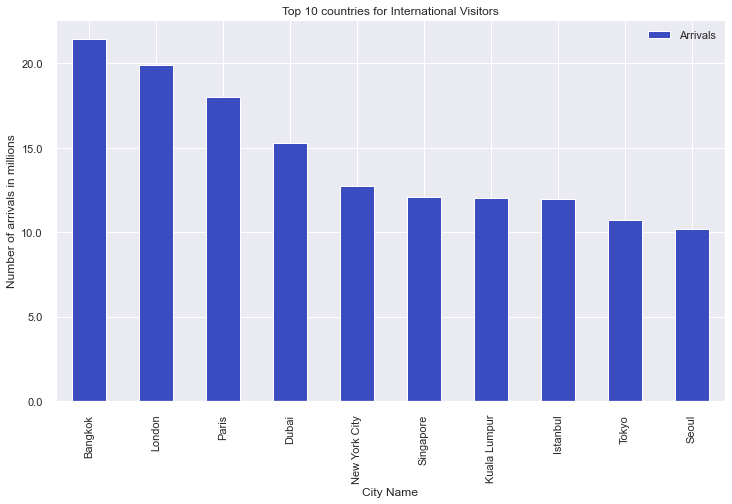

In [63]:
def millions_formatter(x, pos):
    return f'{x / 1000000}'

top_ten = df[['City','Arrivals']].head(10).set_index('City')
axes = top_ten.plot(kind='bar',figsize=(12,7),colormap='coolwarm')
axes.set_title('Top 10 countries for International Visitors')
axes.set_xlabel('City Name')
axes.set_ylabel('Number of arrivals in millions')
axes.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

#### 2.1.1 Visualise the 100 most visited cities using Folium

In [64]:
#First extract coordinates for all 99 cities
latitude = []
longitude = []

for i in range(0,99):
    country = df.iloc[i][2]
    city = df.iloc[i][1]
    address = '{}, {}'.format(city, country)

    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

In [65]:
df['Latitude'] = latitude
df['Longitude'] = longitude

In [81]:
map_world = folium.Map(min_zoom=2)
loop_count = 0
for lat, lng, city, country in zip(df['Latitude'], df['Longitude'], df['City'], df['Country']):
    label = '{}, {}'.format(city, country)
    label = folium.Popup(label, parse_html=True)
    #print(str(df.iloc[loop_count]['Arrivals']/1000000))
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        color='blue',
        radius=df.iloc[loop_count]['Arrivals']/1000000,
        #radius=2,
        fill=True,
        fill_color='#4df3ce',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)  
    loop_count = loop_count + 1
map_world

Many of the cities are in Europe and Asia.  Only 5 African cities appear in the top 100 and only two in Australia

#### 2.1.2 Find countries with similar spending patterns
We can use the income data from Mastercard and K-Means 

In [20]:
#First determine a dollar spend amount per visitor.  Multiply income by 1 billion first to get dollar amount
df['Income Per Arrival'] = (df['Income'] * 1000000000)/df['Arrivals']

In [21]:
df.head()

,Rank,City,Country,Arrivals,Income,Latitude,Longitude,Income Per Arrival,Cluster
0,1.000,Bangkok,Thailand,21470000.000,14.840,13.754,100.493,691.197,1
1,2.000,London,United Kingdom,19880000.000,19.760,51.507,-0.128,993.964,0
2,3.000,Paris,France,18030000.000,12.880,48.857,2.351,714.365,1
3,4.000,Dubai,United Arab Emirates,15270000.000,31.300,25.075,55.189,2049.771,5
4,5.000,New York City,United States,12750000.000,18.520,40.713,-74.006,1452.549,2


Text(0.5, 1.0, 'Arrivals vs Income')

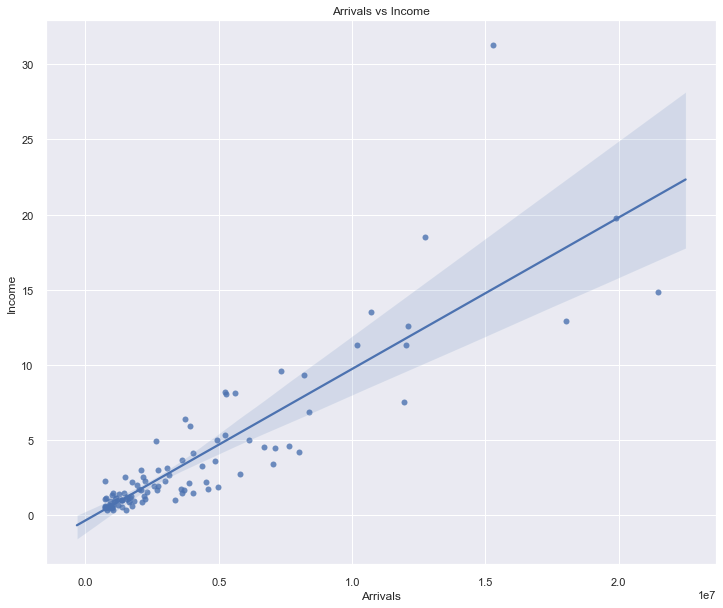

In [22]:
sns.set(rc={'figure.figsize':(12,10)})
sns.regplot(x=df['Arrivals'], y=df['Income']).set_title("Arrivals vs Income")

As might be expected, the amount of income appears to have a linear relationship with arrivals i.e. as arrivals increase so income tends to increase as well.  We can now cluster the countries based on the "Income Per Arrival" column

In [27]:
X = df['Income Per Arrival'].values.reshape(-1, 1)
x_transformed = StandardScaler().fit_transform(X)

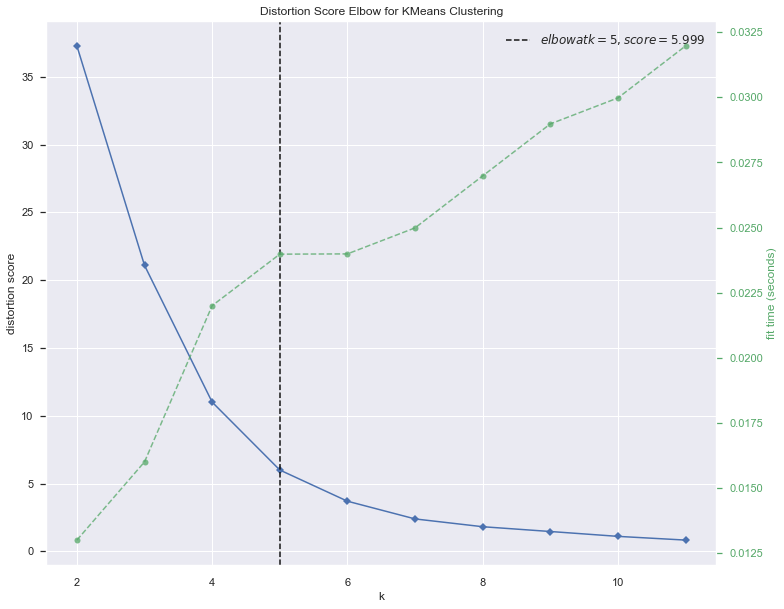

In [28]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(x_transformed) 
visualizer.show()

In [29]:
#Based on the above result will use 6 as the number of clusters
kclusters = 6
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
k_means.fit(x_transformed)
predicted_labels = k_means.predict(x_transformed)
df['Cluster'] = predicted_labels

In [50]:
# create map
map_clusters = folium.Map(min_zoom=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, city, country,cluster in zip(df['Latitude'], df['Longitude'], df['City'], df['Country'],df['Cluster']):
    label = '{}, {}, Cluster: {}'.format(city, country, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        legend_name='Clusters',
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters),       

map_clusters

The minimum and maximum income per arrival for each of the newly created clusters

In [31]:
cluster_df = pd.DataFrame()
cluster_df['Min Value'] = df.groupby('Cluster').min()['Income Per Arrival']
cluster_df['Max Value'] = df.groupby('Cluster').max()['Income Per Arrival']
cluster_df = cluster_df.sort_values('Min Value')

In [32]:
cluster_df

,Min Value,Max Value
Cluster,,
0,203.947,560.000
3,581.818,853.211
2,943.428,1165.138
5,1252.874,1555.344
1,1653.333,2049.771
4,2986.667,2986.667


Text(0, 0.5, 'Income Per Arrival')

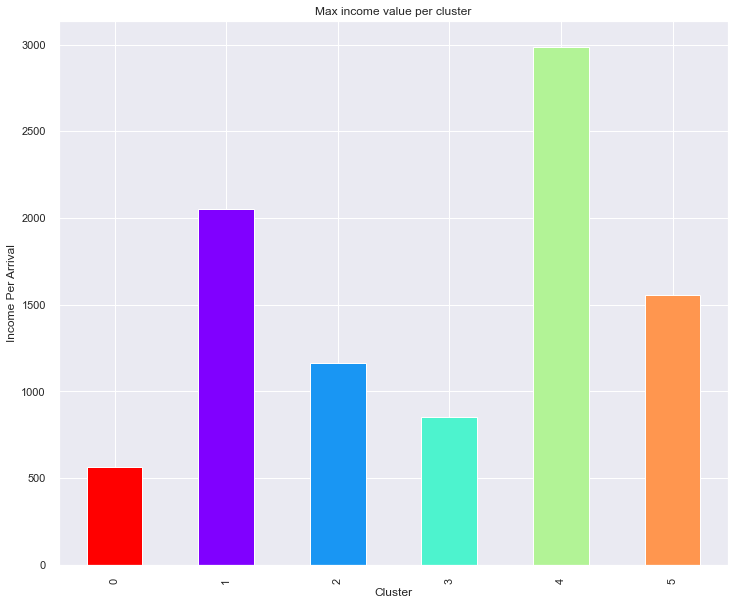

In [59]:
axes = cluster_df.drop(['Min Value'],axis=1).sort_values(by='Cluster').plot(kind='bar',legend=False,color=[['#ff0000','#8000ff','#1996f3','#4df3ce','#b2f396','#ff964f']])
axes.set_title('Max income value per cluster')
axes.set_ylabel('Income Per Arrival')

In [34]:
df[df['Cluster'] == 4]

,Rank,City,Country,Arrivals,Income,Latitude,Longitude,Income Per Arrival,Cluster
94,96.000,Tianjin,China,750000.000,2.240,39.124,117.198,2986.667,4


Tianjin is an outlier in the data due to the relatively low number of arrivals combined with relatively high income

### 2.2  Get the venue information using the Foursquare API

In [177]:
ACCESS_TOKEN = 'RU5FETC52P5GD0RRGTQGYJ0A45RMPHHIDFK40I30GXIF5US5'
CLIENT_ID = '044E0R1REFE11PW3ZDRNRMEWUWT3ZE3OCLWVOJ25FRN1XW4P'
CLIENT_SECRET = 'MJTNYVVZXO3LMI3XCM41BRJLELQKMC2N31BELDDAAMSMGU4S'
VERSION = '20180604'
LIMIT=3000

In [180]:
# I need a function to extract the category of a venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [179]:
# Add a combind country and city column to the dataframe
df['CountryCity'] = df['City'] + ',' + df['Country']

In [178]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'City', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [182]:
nearby_venues = getNearbyVenues(names=df['CountryCity'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Bangkok,Thailand
London,United Kingdom
Paris,France
Dubai,United Arab Emirates
New York City,United States
Singapore,Singapore
Kuala Lumpur,Malaysia
Istanbul,Turkey
Tokyo,Japan
Seoul,South Korea
Hong Kong,Hong Kong
Barcelona,Spain
Amsterdam,Netherlands
Milan,Italy
Taipei,Taiwan
Rome,Italy
Osaka,Japan
Vienna,Austria
Shanghai,China
Prague,Czech Republic
Los Angeles,United States
Madrid,Spain
Munich,Germany
Miami,United States
Dublin,Ireland
Berlin,Germany
Mumbai,India
Riyadh,Saudi Arabia
Toronto,Canada
Chennai,India
Beijing,China
Lima,Peru
San Francisco,United States
Vancouver,Canada
Sydney,Australia
Guangzhou,China
Lisbon,Portugal
Frankfurt am Main,Germany
Johannesburg,South Africa
Budapest,Hungary
Abu Dhabi,United Arab Emirates
Ho Chi Minh City,Vietnam
Mexico City,Mexico
Punta Cana,Dominican Republic
Brussels,Belgium
Athens,Greece
Melbourne,Australia
Delhi,India
São Paulo,Brazil
Zürich,Switzerland
Montreal,Canada
Hanoi,Vietnam
Washington D.C.,United States
Shenzhen,China
Chicago,United

In [183]:
#Writing out the Venues to CSV so I don't need to make additional calls to the API
nearby_venues.to_csv('nearby_venues.csv',index=False)

In [83]:
nearby_venues = pd.read_csv('nearby_venues.csv')
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bangkok,Thailand",13.754,100.493,Temple of the Emerald Buddha (วัดพระศรีรัตนศาส...,13.752,100.493,Buddhist Temple
1,"Bangkok,Thailand",13.754,100.493,Café VeloDome (คาเฟ่ เวโลโดม),13.756,100.492,Café
2,"Bangkok,Thailand",13.754,100.493,Prasat Phra Thep Bidon (ปราสาทพระเทพบิดร),13.752,100.493,Palace
3,"Bangkok,Thailand",13.754,100.493,Thokkathan-Mother Earth Squeezing Her Hair (พร...,13.757,100.495,Spiritual Center
4,"Bangkok,Thailand",13.754,100.493,The Grand Palace (พระบรมมหาราชวัง),13.751,100.492,Palace


One hot encoding can be applied to this newly created dataframe

In [84]:
# one hot encoding
nearby_venues_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nearby_venues_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nearby_venues_onehot.columns[-1]] + list(nearby_venues_onehot.columns[:-1])
nearby_venues_onehot = nearby_venues_onehot[fixed_columns]

nearby_grouped = nearby_venues_onehot.groupby('Neighborhood').mean().reset_index()
nearby_grouped

,Neighborhood,Zoo,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant
0,"Abu Dhabi,United Arab Emirates",0.000,0.000,0.000,0.000,0.020,0.000,0.010,0.000,0.000,...,0.000,0.000,0.000,0.010,0.000,0.000,0.010,0.000,0.000,0.000
1,"Accra,Ghana",0.000,0.000,0.000,0.000,0.078,0.000,0.031,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,"Amman,Jordan",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000
3,"Amsterdam,Netherlands",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,"Athens,Greece",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.010,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Warsaw,Poland",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000
95,"Washington D.C.,United States",0.000,0.000,0.000,0.000,0.000,0.000,0.040,0.000,0.000,...,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
96,"Xi'an,China",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
97,"Xiamen,China",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [85]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Get the top ten most common venues per city

In [86]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nearby_grouped['Neighborhood']

for ind in np.arange(nearby_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nearby_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abu Dhabi,United Arab Emirates",Middle Eastern Restaurant,Café,Coffee Shop,Hotel,Bakery,Dessert Shop,Italian Restaurant,Filipino Restaurant,Indian Restaurant,Ice Cream Shop
1,"Accra,Ghana",African Restaurant,Hotel,Indian Restaurant,Restaurant,Bar,Bakery,Cocktail Bar,Nightclub,American Restaurant,Lounge
2,"Amman,Jordan",Café,Middle Eastern Restaurant,Italian Restaurant,Bar,Juice Bar,Historic Site,Coffee Shop,Bakery,Art Gallery,Dessert Shop
3,"Amsterdam,Netherlands",Hotel,Bar,Coffee Shop,Marijuana Dispensary,Café,Cocktail Bar,Dessert Shop,Clothing Store,Cheese Shop,Bookstore
4,"Athens,Greece",Bar,Coffee Shop,Café,Theater,Greek Restaurant,Hotel,Falafel Restaurant,Souvlaki Shop,Bookstore,Vegetarian / Vegan Restaurant


Text(0, 0.5, 'Number of occurences')

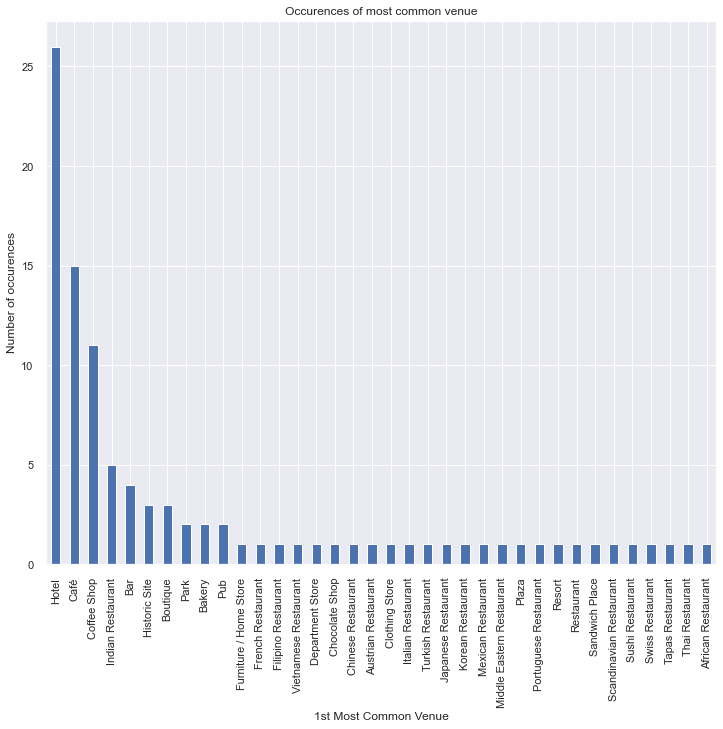

In [96]:
axes = neighborhoods_venues_sorted.groupby('1st Most Common Venue').count()['Neighborhood'].sort_values(ascending=False).plot(kind='bar')
axes.set_title('Occurences of most common venue')
axes.set_ylabel('Number of occurences')

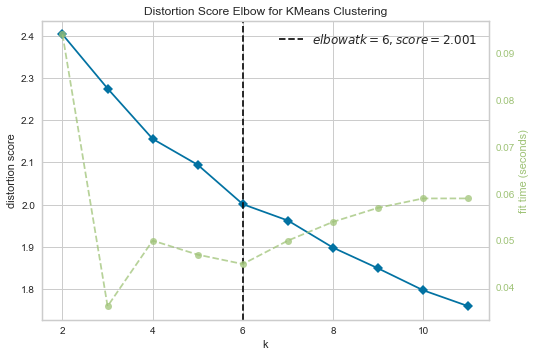

In [199]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(nearby_grouped.drop(['Neighborhood'],axis=1))
visualizer.show()

We can try clustering with a value of 6 as suggested by the elbow method above

In [200]:
# set number of clusters
kclusters = 6

nearby_group_clustering = nearby_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 5, 0, 5, 0, 3, 1, 3, 5, 2])

In [205]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename({'Neighborhood':'CountryCity'},axis=1)

In [206]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with df_toronto to add latitude/longitude for each neighborhood
df = df.join(neighborhoods_venues_sorted.set_index('CountryCity'), on='CountryCity').reset_index(drop=True)

In [208]:
df.head()

,Rank,City,Country,Arrivals,Income,Latitude,Longitude,Income Per Arrival,Cluster,CountryCity,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.000,Bangkok,Thailand,21470000.000,14.840,13.754,100.493,691.197,0,"Bangkok,Thailand",...,Thai Restaurant,Bar,Palace,Coffee Shop,Café,Noodle House,Dessert Shop,Asian Restaurant,History Museum,Art Gallery
1,2.000,London,United Kingdom,19880000.000,19.760,51.507,-0.128,993.964,4,"London,United Kingdom",...,Hotel,Theater,Plaza,Cocktail Bar,Wine Bar,Ice Cream Shop,Garden,Bakery,Restaurant,Spa
2,3.000,Paris,France,18030000.000,12.880,48.857,2.351,714.365,0,"Paris,France",...,French Restaurant,Ice Cream Shop,Plaza,Art Gallery,Bookstore,Cosmetics Shop,Park,Clothing Store,Café,Gourmet Shop
3,4.000,Dubai,United Arab Emirates,15270000.000,31.300,25.066,55.171,2049.771,5,"Dubai,United Arab Emirates",...,Hotel,Coffee Shop,Café,Restaurant,Gym,Spa,Shopping Mall,Indian Restaurant,Breakfast Spot,Lounge
4,5.000,New York City,United States,12750000.000,18.520,40.713,-74.006,1452.549,1,"New York City,United States",...,Coffee Shop,Hotel,Gym,Falafel Restaurant,Spa,French Restaurant,Café,American Restaurant,Cocktail Bar,Italian Restaurant


Plotting the nearly created clusters we get the below map

In [316]:
# create map
map_clusters = folium.Map(min_zoom=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, city, country,cluster,mostcommon in zip(df['Latitude'], df['Longitude'], df['City'], df['Country'],df['Cluster Labels'],df['1st Most Common Venue']):
    label = '{}, {}, Cluster: {},Most Common Venue: {}'.format(city, country, cluster,mostcommon)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        legend_name='Clusters',
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters),       

map_clusters

### We can analyse the composition of the newly created clusters.  First I'll create a dataframe containing just the cluster, city and then the venue type rankings

In [333]:
analysis_df_all = df[['City','Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue']]

In [339]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df.groupby('Cluster Labels').count().sort_values('Cluster Labels',ascending=True)

,City,variable,value
Cluster Labels,,,
0,270,270,270
1,50,50,50
2,30,30,30
3,240,240,240
4,90,90,90
5,310,310,310


Clusters 1,2 and 3 have far fewer venues assigned than the other clusters

In [323]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df = analysis_df[analysis_df['Cluster Labels'] == 0]
analysis_df.groupby('value').count().sort_values('variable',ascending=False).head(15)

,City,Cluster Labels,variable
value,,,
Café,25,25,25
Coffee Shop,19,19,19
Hotel,16,16,16
Bar,13,13,13
Restaurant,12,12,12
Italian Restaurant,11,11,11
Plaza,8,8,8
Bakery,8,8,8
Cocktail Bar,6,6,6


Cluster zero (in red) consists largely of cafe, coffee shop, hotel and bar.

In [325]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df = analysis_df[analysis_df['Cluster Labels'] == 1]
analysis_df.groupby('value').count().sort_values('variable',ascending=False).head(15)

,City,Cluster Labels,variable
value,,,
Indian Restaurant,5,5,5
Hotel,4,4,4
Ice Cream Shop,3,3,3
Café,3,3,3
Chinese Restaurant,3,3,3
Coffee Shop,3,3,3
Sandwich Place,2,2,2
Fast Food Restaurant,2,2,2
Dessert Shop,2,2,2


Cluster one (in purple on the map) consists of only countries in India.  The primary similarity seems to relate to the "Indian Restaurant" label.  This may explain why this cluster is so smaller than the others

In [326]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df = analysis_df[analysis_df['Cluster Labels'] == 2]
analysis_df.groupby('value').count().sort_values('variable',ascending=False).head(15)

,City,Cluster Labels,variable
value,,,
Historic Site,3,3,3
Hotel,3,3,3
Café,2,2,2
Coffee Shop,2,2,2
Bar,1,1,1
Ice Cream Shop,1,1,1
Tea Room,1,1,1
Scenic Lookout,1,1,1
Pub,1,1,1


Cluster two (in blue) consists largely of historic sites.  This cluster has the least venue information

In [340]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df = analysis_df[analysis_df['Cluster Labels'] == 3]
analysis_df.groupby('value').count().sort_values('variable',ascending=False).head(15)

,City,Cluster Labels,variable
value,,,
Coffee Shop,20,20,20
Café,15,15,15
Hotel,11,11,11
Park,7,7,7
Japanese Restaurant,7,7,7
Indian Restaurant,6,6,6
Chinese Restaurant,6,6,6
Bakery,6,6,6
Restaurant,6,6,6


Cluster three (in turquoise) consists largely of coffee shops, cafe's and hotels

In [341]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df = analysis_df[analysis_df['Cluster Labels'] == 4]
analysis_df.groupby('value').count().sort_values('variable',ascending=False).head(15)

,City,Cluster Labels,variable
value,,,
Coffee Shop,9,9,9
Hotel,9,9,9
Shopping Mall,7,7,7
Café,4,4,4
Chinese Restaurant,4,4,4
Electronics Store,4,4,4
Park,3,3,3
Hotpot Restaurant,3,3,3
Movie Theater,2,2,2


Cluster four (in green) only appears in east Asia.  It includes "Hotpot Restaurant" which only appears in this cluster

In [342]:
analysis_df = analysis_df_all.melt(['City','Cluster Labels'])
analysis_df = analysis_df[analysis_df['Cluster Labels'] == 5]
analysis_df.groupby('value').count().sort_values('variable',ascending=False).head(15)

,City,Cluster Labels,variable
value,,,
Hotel,30,30,30
Coffee Shop,19,19,19
Plaza,16,16,16
Restaurant,14,14,14
Bar,13,13,13
Cocktail Bar,11,11,11
Café,11,11,11
Theater,8,8,8
Italian Restaurant,8,8,8


Going back to the 

In [107]:
clustering_and_rank

,Rank,City,Cluster
0,1,Bangkok,3
0,2,London,0
0,3,Paris,5
0,4,Dubai,3
0,5,New York City,3
0,6,Singapore,3
0,7,Kuala Lumpur,3
0,8,Istanbul,5
0,9,Tokyo,0
0,10,Seoul,3


Cluster 5 is appears quite heavily in Europe.  Most common instance in this cluster is "Hotel"

### 3.  Conclusion

We've analysed popular travel destinations, focusing on number of visitors, money spent and similarity of each city.

We see that there is a fairly linear relationship between number of arrivals and income earned and were able to cluster the cities based on average spend per arrival.

We further split the 100 most visited cities based on an exploration of venues using the Foursquare API

In the future, further analysis can be done to find find overlapping income and similarity clusters.  For example, while spend in Australia is higher than in Durban, the cluster analysis suggests that these are similar regions.  This may make Durban an attractive alternate destination for travelers .